In [1]:
#!pip install -U scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
#import pandas.core.common import flatten

<Figure size 720x1080 with 0 Axes>

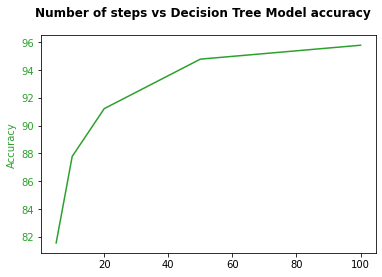

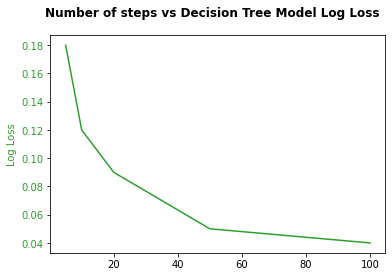

In [5]:
#And we run the number of steps with our best model to see how the number of steps relates with the 
#moels performance. The ideal scenario is when we have the least amount of steps with the highest
#confidence (lowest log error) our model has in the results. 
#We simply add the updated hyperparameters and give each step as input. 
def get_step_results(no_of_robot_steps):
    fixed_wheel_x = np.loadtxt(str(no_of_robot_steps) + "_steps_fixed_xs.csv", delimiter=',')
    fixed_wheel_y = np.loadtxt(str(no_of_robot_steps) + "_steps_fixed_ys.csv", delimiter=',')
    fixed_wheel_theta = np.loadtxt(str(no_of_robot_steps) + "_steps_fixed_thetas.csv", delimiter=',')

    omni_wheel_x = np.loadtxt(str(no_of_robot_steps) + "_steps_omni_xs.csv", delimiter=',')
    omni_wheel_y = np.loadtxt(str(no_of_robot_steps) + "_steps_omni_ys.csv", delimiter=',')
    omni_wheel_theta = np.loadtxt(str(no_of_robot_steps) + "_steps_omni_thetas.csv", delimiter=',')

    two_wheel_x = np.loadtxt(str(no_of_robot_steps) + "_steps_two_fixed_xs.csv", delimiter=',')
    two_wheel_y = np.loadtxt(str(no_of_robot_steps) + "_steps_two_fixed_ys.csv", delimiter=',')
    two_wheel_theta = np.loadtxt(str(no_of_robot_steps) + "_steps_two_fixed_thetas.csv", delimiter=',')

    #Get parameters of the dataframe we will need to build
    len_of_steps = len(fixed_wheel_x[0])
    total_len_of_columns = len_of_steps * 3
    total_pose_size = len(fixed_wheel_x.flatten()) + len(fixed_wheel_y.flatten()) + len(fixed_wheel_theta.flatten())
    total_pose_size = int(total_pose_size/total_len_of_columns)

    #print("Number of robot steps: ", len_of_steps, "\nLenght of columns for steps (x,y,theta): ",total_len_of_columns, "\nTotal number of samples: ", total_pose_size)

    #Expose and reshape the measurements in the respective wheels 
    #to build a dataframe for the wheeltype
    fixed_wheel_poses = np.column_stack((fixed_wheel_x.flatten(),fixed_wheel_y.flatten(),fixed_wheel_theta.flatten()))
    fixed_wheel_poses = np.reshape(fixed_wheel_poses,(total_pose_size,total_len_of_columns))

    omni_wheel_poses = np.column_stack((omni_wheel_x.flatten(),omni_wheel_y.flatten(),omni_wheel_theta.flatten()))
    omni_wheel_poses = np.reshape(omni_wheel_poses,(total_pose_size,total_len_of_columns))
    
    two_fixed_wheel_poses = np.column_stack((two_wheel_x.flatten(),two_wheel_y.flatten(),two_wheel_theta.flatten()))
    two_fixed_wheel_poses = np.reshape(two_fixed_wheel_poses,(total_pose_size,total_len_of_columns))

    #Creating the column names. Each measurement contains a X,y and theta value
    x_headings = ["step x " + str(i+1) for i in range(int(total_len_of_columns/3))]
    y_headings = ["step y " + str(i+1) for i in range(int(total_len_of_columns/3))]
    theta_headings = ["step theta " + str(i+1) for i in range(int(total_len_of_columns/3))]
    headings = []
    for i in range(0,len(x_headings)):
        headings.append(x_headings[i])
        headings.append(y_headings[i])
        headings.append(theta_headings[i])
    #headings = x_headings + y_headings + theta_headings
    #headings

    #Creating the respective wheel dataframes
    fixed_p = pd.DataFrame(fixed_wheel_poses, columns = headings)
    omni_p = pd.DataFrame(omni_wheel_poses, columns = headings)
    two_fixed_p = pd.DataFrame(two_fixed_wheel_poses, columns = headings)

    #Tagging class labels in a new column with the wheel type 
    #and joining the dataframes into one, we shuffle the dataframe
    #and reset the index
    fixed_p.insert(0,'Model type', 'fw')
    omni_p.insert(0,'Model type', 'ow')
    two_fixed_p.insert(0,'Model type', 'tf')
    wheel_poses = pd.concat([fixed_p, omni_p, two_fixed_p])
    wheel_poses = wheel_poses.iloc[np.random.RandomState(seed=16).permutation(len(wheel_poses))]
    wheel_poses = wheel_poses.reset_index(drop=True)

    X = wheel_poses.drop(columns='Model type')
    y = wheel_poses['Model type']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=16)
 
    
    reg_best_log_steps = DecisionTreeClassifier(min_samples_split= 3, min_samples_leaf= 3, max_leaf_nodes=80, max_depth=5, criterion= 'gini')
    reg_best_log_steps.fit(X_train, y_train)
    y_pred_tuned_dt = reg_best_log_steps.predict(X_test)

    dic_acc = {}
    dic_zol = {}
    
    #confusion_matrix = metrics.plot_confusion_matrix(reg_best_log_steps, X_test, y_test)
    #print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_tuned_dt))
    #print(confusion_matrix)

    y_pred_prob = reg_best_log_steps.predict_proba(X_test)[:,1]


    dic_acc['ACC'] = round(metrics.accuracy_score(y_test, y_pred_tuned_dt)*100,2)
    dic_zol['Zero One Loss'] = round(metrics.zero_one_loss(y_test, y_pred_tuned_dt),2)
    
    model_name = str(len_of_steps) + '_steps_DT_robot_model_weights.sav' 
    pickle.dump(reg_best_log_steps, open(model_name, 'wb'))
    
    return dic_acc, dic_zol


steps = [5, 10, 20, 50, 100]
#steps = [100, 500, 1000, 2000, 5000,10000]

step_dic = {}
#Collects the accuracy and log loss for each step
#steps = [5]

for no_of_robot_steps in steps:
    step_acc, step_zol = get_step_results(no_of_robot_steps)
    step_dic[no_of_robot_steps] = [step_acc, step_zol]
    
k_list = []
v_list = []
z_list = []
for k, v in step_dic.items():
    k_list.append(k) 
    v_list.append(list(v[0].values())[0])
    z_list.append(list(v[1].values())[0])
    #print("For step: ", k, "the results are: ", v )

plt.figure(figsize=(10,15))
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_ylabel('Accuracy', color = color)
ax1.plot(k_list, v_list, color = color)
ax1.tick_params(axis ='y', labelcolor = color)
fig.suptitle('Number of steps vs Decision Tree Model accuracy\n', fontweight ="bold")
plt.show()

fig2, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_ylabel('Log Loss', color = color)
ax1.plot(k_list, z_list, color = color)
ax1.tick_params(axis ='y', labelcolor = color)
fig2.suptitle('Number of steps vs Decision Tree Model Log Loss\n', fontweight ="bold")
plt.show()

    


In [21]:
step_dic

{5: [{'ACC': 70.33}, {'Zero One Loss': 0.3}],
 10: [{'ACC': 87.0}, {'Zero One Loss': 0.13}],
 20: [{'ACC': 91.22}, {'Zero One Loss': 0.09}],
 50: [{'ACC': 94.78}, {'Zero One Loss': 0.05}],
 75: [{'ACC': 95.44}, {'Zero One Loss': 0.05}],
 90: [{'ACC': 95.67}, {'Zero One Loss': 0.04}],
 100: [{'ACC': 96.67}, {'Zero One Loss': 0.03}]}